<h1 align="center">Planet: Understanding the Amazon from Space</h1>
![](https://kaggle2.blob.core.windows.net/competitions/kaggle/6322/logos/header.png)
<h2 align="center">Using satellite data to track the human footprint in the Amazon rainforest</h2>


In [1]:
%autosave 1800

Autosaving every 1800 seconds


In [2]:
import sys
import subprocess
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib
matplotlib.rcParams['font.sans-serif'].insert(0, 'Liberation Sans')
matplotlib.rcParams['font.sans-serif'].insert(0, 'Arial')
matplotlib.rcParams['font.family'] = 'sans-serif'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from skimage import io
import scipy
from scipy import ndimage
from IPython.display import display
import rasterio # reads and writes geospatial raster datasets

# Time to get straight into data:
Set PLANET_KAGGLE_ROOT to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [3]:
PLANET_KAGGLE_ROOT = os.path.abspath('/resources/data/Kaggle/amazon/')

print('# File sizes')
for f in os.listdir('/resources/data/Kaggle/amazon/'):
    if not os.path.isdir('/resources/data/Kaggle/amazon/' + f):
        print(f.ljust(30) + str(round(os.path.getsize('/resources/data/Kaggle/amazon/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize('/resources/data/Kaggle/amazon/'+f+'/'+x)/1000000 for x in os.listdir('/resources/data/Kaggle/amazon/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
test-tif.tar                  21958.48MB
test-tif                      21930.25MB (40669 files)
test-jpg                      637.8MB (40669 files)
train-tif                     21819.98MB (40479 files)
train.csv                     1.43MB
sample_submission.csv         1.94MB
train-jpg                     634.68MB (40479 files)
train-tif.tar                 21848.07MB


In [4]:
label_csv = os.path.join('/resources/data/Kaggle/amazon/test-tif', '/resources/data/Kaggle/amazon/train.csv')

In [5]:
label_csv

'/resources/data/Kaggle/amazon/train.csv'

In [6]:
labels_df =  pd.read_csv(label_csv)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


- we have 40k images for training, and 40k images for testing. 
- The jpegs are on average **15KB**, and the tifs are on average **538KB**. 
- The JPEGs seem a little on the small side, but TIFFs look like they will retain most of the quality.

Let's take a look at the train.csv:

# Training data

In [7]:
labels_df = pd.read_csv("/resources/data/Kaggle/amazon/train.csv")
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
labels_df.tail()

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [9]:
labels_df.describe()

,image_name,tags
count,40479,40479
unique,40479,458
top,train_21968,clear primary
freq,1,13636


The training metadata is super basic. It looks like we are just given names and corresponding tags. Let's parse them and do some analysis

In [11]:
labels = labels_df['tags'].apply(lambda x: x.split(' '))

In [13]:
labels[1]

['agriculture', 'clear', 'primary', 'water']

In [14]:
from collections import Counter, defaultdict
counts = Counter()
for label in labels:
    counts += Counter(label)

In [15]:
# Build list with unique labels
labels_list = list(counts.keys())
len(labels_list)

17

In [16]:
# Add one-hot encoded features for every label
for label in labels_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
# display head
labels_df.head()

,image_name,tags,slash_burn,agriculture,habitation,artisinal_mine,cultivation,clear,blooming,water,road,selective_logging,haze,partly_cloudy,primary,cloudy,bare_ground,blow_down,conventional_mine
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [17]:
data = [go.Bar(x = list(counts.keys()), y=list(counts.values()))]
layout = dict(height=800, width=800, title='Distribution of training labels')
fig = dict(data=data, layout=layout)
py.iplot(data)

/resources/common/.virtualenv/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



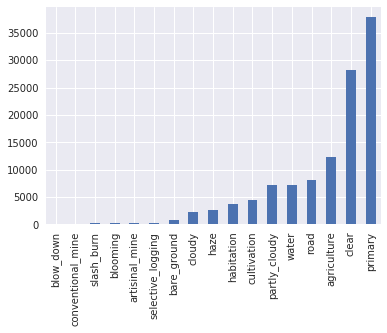

In [18]:
# Same Histogram of label instances
labels_df[labels_list].sum().sort_values().plot.bar()

# Co-Occurence Matrix
A co-occurrence matrix stores the count of how often a particular pair of things occurred together.   

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
def make_coocurence_matrix(labels):
    numeric_df = labels_df[labels];
    c_matrix = numeric_df.T.dot(numeric_df)
    scaler = MinMaxScaler()
    c_matrix.loc[:,:] = scaler.fit_transform(c_matrix) 
    data = [go.Heatmap(z=c_matrix.T.values.tolist(), x = list(c_matrix[:0][:]), y=list(c_matrix[:0][:]), colorscale='Viridis')]
    layout = go.Layout(height = 600, width =500, title='Co-occurence matrix of training labels')
    fig = dict(data=data, layout=layout)
    py.iplot(data)
    return c_matrix


# Compute the occurence matrix
make_coocurence_matrix(labels_list)


,slash_burn,agriculture,habitation,artisinal_mine,cultivation,clear,blooming,water,road,selective_logging,haze,partly_cloudy,primary,cloudy,bare_ground,blow_down,conventional_mine
slash_burn,1.000000,0.007876,0.010656,0.000000,0.028144,0.006134,0.006024,0.002893,0.004211,0.005882,0.001113,0.004551,0.003047,0.000000,0.011641,0.020408,0.00
agriculture,0.569378,1.000000,0.747268,0.112094,0.754300,0.324434,0.096386,0.374018,0.747337,0.191176,0.249351,0.343677,0.315159,0.010300,0.261932,0.224490,0.24
habitation,0.196172,0.220445,1.000000,0.085546,0.199911,0.109563,0.012048,0.125637,0.344934,0.038235,0.047866,0.060819,0.089466,0.000858,0.189756,0.030612,0.36
artisinal_mine,0.000000,0.001299,0.007377,1.000000,0.004021,0.010885,0.000000,0.040777,0.013376,0.017647,0.001855,0.003724,0.006093,0.000000,0.046566,0.000000,0.04
cultivation,0.602871,0.272410,0.243989,0.053097,1.000000,0.125058,0.105422,0.119162,0.160020,0.170588,0.074954,0.103158,0.115535,0.000000,0.103609,0.081633,0.04
clear,0.827751,0.741150,0.843716,0.905605,0.787804,1.000000,0.936747,0.726546,0.779415,0.905882,0.000000,0.000000,0.730514,0.000000,0.866123,0.867347,0.70
blooming,0.009569,0.000812,0.000546,0.000000,0.007818,0.011027,1.000000,0.001791,0.000991,0.020588,0.001484,0.002345,0.006305,0.000000,0.003492,0.010204,0.00
water,0.114833,0.218902,0.249454,0.882006,0.193880,0.187108,0.048193,1.000000,0.263190,0.144118,0.227458,0.177493,0.184470,0.036481,0.239814,0.030612,0.26
road,0.172249,0.488308,0.760929,0.324484,0.289033,0.223203,0.030120,0.292602,1.000000,0.444118,0.146197,0.190594,0.202379,0.002146,0.376019,0.020408,0.59
selective_logging,0.009569,0.003491,0.003005,0.017699,0.012955,0.010921,0.021084,0.006337,0.018454,1.000000,0.001855,0.003724,0.006517,0.000000,0.015134,0.010204,0.00


In [21]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_coocurence_matrix(weather_labels)

,clear,partly_cloudy,haze,cloudy
clear,1.0,0.0,0.0,0.0
partly_cloudy,0.0,1.0,0.0,0.0
haze,0.0,0.0,1.0,0.0
cloudy,0.0,0.0,0.0,1.0


In [22]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_coocurence_matrix(land_labels)

,primary,agriculture,water,cultivation,habitation
primary,1.000000,0.963825,0.967939,0.993904,0.930972
agriculture,0.247869,1.000000,0.289334,0.695206,0.665703
water,0.104338,0.000000,1.000000,0.000000,0.007228
cultivation,0.028630,0.068503,0.000000,1.000000,0.000000
habitation,0.000000,0.001975,0.007351,0.007481,1.000000


In [23]:
rare_labels = [label for label in labels_list if labels_df[labels_list].sum()[label] < 2000]
make_coocurence_matrix(rare_labels)

,slash_burn,artisinal_mine,blooming,selective_logging,bare_ground,blow_down,conventional_mine
slash_burn,1.000000,0.000000,0.006024,0.005882,0.008178,0.020408,0.00
artisinal_mine,0.000000,1.000000,0.000000,0.017647,0.043224,0.000000,0.04
blooming,0.009569,0.000000,1.000000,0.020588,0.000000,0.010204,0.00
selective_logging,0.009569,0.017699,0.021084,1.000000,0.011682,0.010204,0.00
bare_ground,0.047847,0.117994,0.009036,0.038235,1.000000,0.040816,0.10
blow_down,0.009569,0.000000,0.003012,0.002941,0.001168,1.000000,0.00
conventional_mine,0.000000,0.011799,0.000000,0.000000,0.008178,0.000000,1.00


In this context, **this co-occurence matrix shows what percentage of the X label also has the Y label**.
# Images

## Helper function to select sample images

In [24]:
from six import string_types
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags"""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
        
    if n is not None:
        return labels_df[condition].sample(n)
    
    else:
        return labels_df[condition]

## Helper function to find image

In [25]:
def find_image(filename):
    
    
    for dirname in os.listdir('/resources/data/Kaggle/amazon/'):
        path = os.path.abspath(os.path.join('/resources/data/Kaggle/amazon/', dirname, filename))
        if os.path.exists(path):
            print('Found Image {}'.format(path))
            return path
        else:
            print('Oops! Imag not found at {}'.format(path))
            

## Helper function to load an image

In [26]:
def load_image(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = find_image(filename)
    if path:
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
    else:
        print('Load Failed: could not find image {}'.format(path))

Let's plot some images and look at their histogram of pixel values in each channel.

In [27]:
image_path = sample_images(['primary', 'water', 'road'], n=1)['image_name'].iloc[0]
rgbn_image = load_image(image_path+'.tif')
rgb_image = rgbn_image[:, :, :3]

Oops! Imag not found at /resources/data/Kaggle/amazon/test-tif.tar/train_37616.tif
Oops! Imag not found at /resources/data/Kaggle/amazon/test-tif/train_37616.tif
Oops! Imag not found at /resources/data/Kaggle/amazon/test-jpg/train_37616.tif
Found Image /resources/data/Kaggle/amazon/train-tif/train_37616.tif


/resources/common/.virtualenv/python3/lib/python3.4/site-packages/rasterio/__init__.py:193: UserWarning:

Dataset has no geotransform set.  Default transform will be applied (Affine.identity())



In [28]:
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]

/resources/common/.virtualenv/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



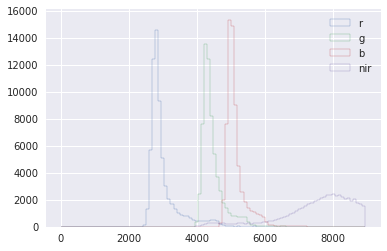

In [52]:
for slice_, name, color in ((r, 'r', 'red'), (g,'g', 'green'), (b, 'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100, range=[0, rgb_image.max()], label=name, histtype='step')
    
plt.legend()
plt.show()

Let's look at each channel individually:


/resources/common/.virtualenv/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



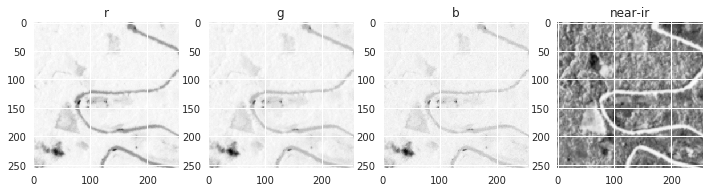

In [55]:
fig = plt.figure(figsize=(12, 8))
for i, (x, c) in enumerate (((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

/resources/common/.virtualenv/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



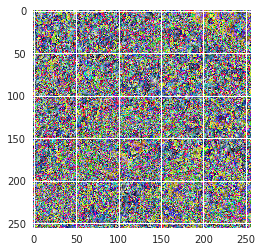

In [56]:
plt.imshow(rgb_image)